# Part 3 - Predicting the Jobs number - Course correction

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

I am making some changes in course due to new discoveries about the data and also refocusing effort.

The first changes should be clear, I am going to start using Jupyter notebooks as the format for my posts.  The whole point is to show some of the methods and Jupyter notebooks provide a great way to do that.  Thanks to the folks at fastai for their tools and tutorials to help me get started with this.

As with any project, I learn new things as I go along, especiall about the data.

I had said in an earlier post that I would pull the U. of Michigan survey data from the U. Mich site because there was a delay of a month for the data to be available on FRED.  Well, it's not just FRED but overall.  I believe there is some arrnagement with Bloomberg to not publish the data elsewhere for a month.  I also believe that the overall consumer score can be scrapped from the U. Mich site, but not the results for the 5 questions that make up the overall score.  So, the forward looking question results *will* have a delay of 1 month.  Later I will give some notebook code to pull the data from the U. Michigan site automatically using Selenium with Python.  And I guess I will use the overall score and get that from the U. Michigan site.

Another change is that I will add the OECD Consumer and Business confidence indexes to the predictor variables.  I found how to get them via FRED.  There are API's that should work directly with the OECD but if I can get it from FRED then that is much easier for me since I already know how to use one of the Python APIs for that.

Speaking of data in general, I found this note from the SF Fed, https://www.frbsf.org/education/publications/doctor-econ/2013/october/labor-market-indicators-monetary-policy-unemployment-rate/
Seems that I am using a lot of the data sources that the fed uses.  
I am going to add a few of the series mentioned in that document.

One other change not so much related to data but to priorities.  I will spend less time on developing a standard time series regression model.  I am more interested in what I can do with a machine learning ensemble method as well as with a neural net model.

I still have to deal with data at different frequencies. A big shout out to Tom Stark, https://www.philadelphiafed.org/research-and-data/research-contacts/stark, at the Philadelphia Fed for sending me some advice on how to deal with this.  He says to use a Kalman filter. And Tom was nice enough to send me his notes on the subject, comprising of 4 PDF files and over 350 pages.  Very nice Tom, what a real gem you are.

With that as an intro to Part 3, let's get started getting data from FRED.

In [25]:
import os
import sys
import datetime
import pandas as pd
import numpy as np
from plotnine import ggplot
import matplotlib as mpl
import matplotlib.pyplot as plt
print("Python version= {0}".format(sys.version_info))
print("Pandas version= {0}".format(pd.__version__))
print("Datetime= {0}".format(datetime.datetime.now()))

Python version= sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
Pandas version= 1.1.3
Datetime= 2020-10-29 08:45:24.762121


## Getting data from FRED using a Python API

The FRED website itself has a pretty nice GUI for plotting data. But I need to download the data so I can use Python or R tools to do the forecasting.

The FRED website gives links to projects you can use to access the FRED data from a variety of languages.
See https://fred.stlouisfed.org/docs/api/fred/
I have used the python one called fredapi, https://github.com/mortada/fredapi, before and will use it here with one modification.  
I will add arguments to limit the series start and end dates.

To use any of the API tools you will need an API Key.
See the instructions here, https://fred.stlouisfed.org/docs/api/api_key.html, to get one and get started.
I keep mine in a file called "fred_api_key".
The fredapi module is in a sibling directory so I add that to my path before importing the module.


In [26]:
sys.path.append('../../fredapi')
from fredapi import fred
import fredapi
Fred = fred.Fred(api_key_file="fred_api.key")
print(fredapi.__version__)

0.4.2


## How to identify the data on FRED
To acces the data for a series from FRED you need to know the series id.
You can use the fredapi to search for a series given keywords. 
I already know the series ids I want to use and have them in a csv file, so let's read that in and see the ids and a brief description of the data for each one.

In [27]:
fred_ids = pd.read_csv('fred_ids.csv', index_col=None, sep='|')
fred_ids

,series_id,description
0,USPRIV,BLS private
1,NPPTTL,ADP
2,ICSA,Initial Claims
3,CCSA,Continued Claims
4,JTS1000JOL,Job Openings: Total Private
5,JTS1000HIL,Hires: Total Private
6,JTS1000TSL,Total Separations: Total Private
7,CSCICP03USM665S,OECD US Consumer Confidence
8,BSCICP03USM665S,OECD Business Confidence
9,UNRATE,Unemployment Rate


## Calling fredapi to get observations
Now we call the fredapi to get the observations for each series.  I'm only getting the data back to the start of 2007.  I'll print out the number of observations we get of reach series and we will notice the different frequencies.

In [28]:
dfs = []
obs_start = "2007-01-01"
obs_end = datetime.date.today()
for ser in fred_ids.itertuples():
    print(ser.series_id, end=', ')
    try:
        all_df = Fred.get_series_all_releases(series_id=ser.series_id, observation_start=obs_start, observation_end=obs_end)
        tdf = all_df.sort_values(by="realtime_start", ascending=True).groupby(by="date").head(1)   
        tdf['series_id'] = ser.series_id
        tdf['date'] = tdf['date'].dt.date  
        print("rows= {0}".format(tdf.shape[0]))
        dfs.append(tdf)
    except Exception as exc:
        print(exc)
obs_df = pd.concat(dfs)
# merge to add descriptions
obs_df = obs_df.merge(fred_ids, on='series_id')
obs_df.sort_values(by="date", inplace=True)
obs_df['dtime'] = pd.to_datetime(obs_df['date'])  
print(obs_df.tail(4))

USPRIV, rows= 165
NPPTTL, rows= 165
ICSA, rows= 721
CCSA, rows= 720
JTS1000JOL, rows= 164
JTS1000HIL, rows= 164
JTS1000TSL, rows= 164
CSCICP03USM665S, rows= 165
BSCICP03USM665S, rows= 165
UNRATE, rows= 165
UNEMPLOY, rows= 165
CLF16OV, rows= 165
UEMP27OV, rows= 165
U6Rate, rows= 165
CIVPART, rows= 165
LNS12032194, rows= 165
     realtime_start        date      value series_id         description  \
1048     2020-10-15  2020-10-10     898000      ICSA      Initial Claims   
1049     2020-10-22  2020-10-17     787000      ICSA      Initial Claims   
1770     2020-10-29  2020-10-17  7.756e+06      CCSA   Continued Claims    
1050     2020-10-29  2020-10-24     751000      ICSA      Initial Claims   

          dtime  
1048 2020-10-10  
1049 2020-10-17  
1770 2020-10-17  
1050 2020-10-24  


## High Frequency trading with FRED data
Note that the initial claims release came out at 8:30 AM ET today.  
I didn't see the new release on FRED for about 10 minutes.  So don't plan on using FRED for high frequency trading. Scrape it from the source if you need that.

## First look at the data

Let's have a look at the series observations over time.
Note, I tried making a similar plot with Seaborn and plotnine ggplot but but where extremely slow.
Might look into that more but for now just using Matplotlib and do the faceting myself.

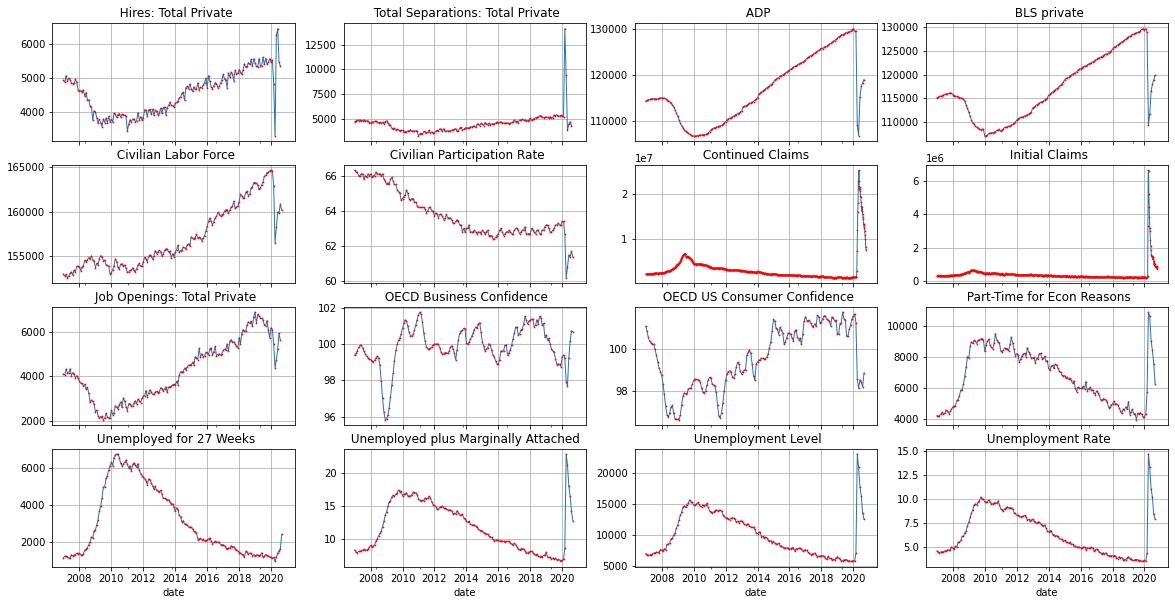

In [29]:
def plot_observations(data_df, xcol, ycol, idcol, ncols, figwd, fight, ylim=(None, None), sharex=True,
                     xlab_rot=0):
    ids = list(data_df[idcol].unique())
    figrows = int(np.ceil(len(ids)/float(ncols)))
    fig, axs = plt.subplots(nrows=figrows, ncols=ncols, figsize=[figwd, fight], sharex=sharex)
    gdf = data_df.groupby(by='description')
    for i, (key, group) in enumerate(gdf):
        row = i // ncols
        col = i % ncols
        ax = axs[row][col]
        group.plot(ax=ax, kind='line', x=xcol, y=ycol,linestyle='-', marker='o', lw=1, ylim=ylim,
                   mec='red', mfc='black', ms=0.75,  title=key, legend=None, label=None, grid=True)
        ax.tick_params(axis='x', labelrotation=xlab_rot)        
    return fig  
ylim=(None, None)
fig = plot_observations(data_df=obs_df, xcol='date', ycol='value', idcol='description', ncols=4,
                  figwd=20, fight=10, ylim=(None,None)) 

I'll refrain from too many comments because interpretation is not the goal right now.
The goal is to gather the data and use it to make a prediction.
In any case, I will make a few comments on the plots above.
* For now ignore the units which can be wildly different
* What a shock to the employment situation we've had this year.
 - Note that in many ways it dwarfs the impact from the 2008 financial crisis.
* OECD Business confidence index has bounced back.  Not so much for consumer confidence.
* Our target is BLS private.  Looks like the ADP data is tracking it really well.  And ADP comes out the week before so maybe that is all we need for a prediction.

Let's zoom in on the past year as that is where we see the big regime change.

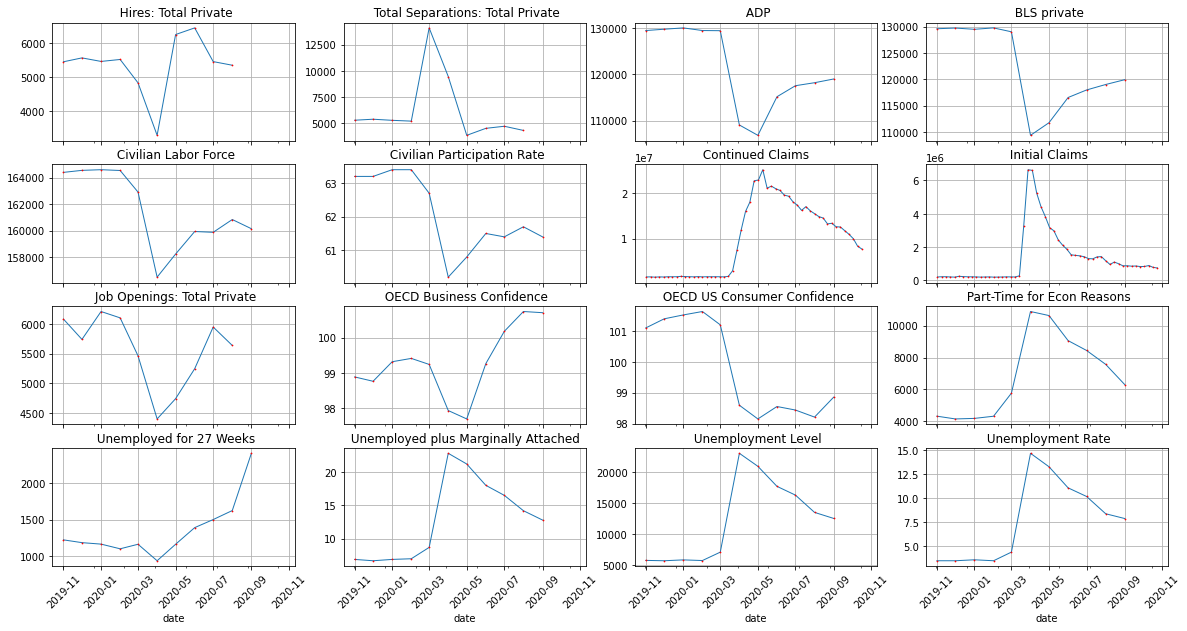

In [30]:
temp_df = obs_df[obs_df['date'] >= datetime.date.today() - datetime.timedelta(weeks=52)]
ylim=(None, None)
fig = plot_observations(data_df=temp_df, xcol='date', ycol='value', idcol='description', ncols=4,
                  figwd=20, fight=10, ylim=(None,None), xlab_rot=45) 

## Data from this year

Still looks like the ADP series is close to the BLS but not spot on.

Also note the difference in the timeliness of the data.  The JOLTS data, hirings, layoffs and openings are from August whereas the initial claims are up to 10-24.

## Seasonal Adjustments
Note to self and you, must think about *seasonal adjustments*.  Which of the series are seasonally adjusted and which are not? How much does it matter?  Is the target seasonally adjusted?